# 1.2 Geospatial Data Analysis

Imports

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

# raster package to work with TIFF
import rasterio as rs
from rasterio.plot import show

# import tqdm to visualize progress in loops
from tqdm import tqdm
import time

# Print all columns of a datafame
pd.set_option('display.max_columns', None)

# Table of Content

* [Introduction](#introduction)
* [Geospatial Data](#geospatial-data)
* [Data Loading](#data-loading)
* [Data Cleaning](#data-cleaning)
* [EDA](#eda)

---

## Introduction <a id="introduction"></a>

**Streamlining Renewable Energy Site Selection with ML:
Predict the Suitability of Solar Energy Resources**

The goal of this project is to apply machine learning techniques to classify whether solar is suitable as the primary energy source for a location.

This can help energy decision makers and energy companies to simplify the complex site selection process, thereby accelerating the transition to clean and sustainable energy sources, ultimately contributing to the fight against climate change and energy crisis. 

This notebook will investigate the raster maps and extract the geospatial data using the Longitude and Latitude of the power plants. We will also do some cleaning and EDA on the merged dataframe.

---

## GeoSpatial Data <a id="geospatial-data"></a>

The geospatial data that we want to extract is stored in the Raster data format as GeoTiff files. Raster is a digital aerial imagery from satellite. It consists a matrix of pixels where each cell contains a value representing geospatial information. 

There are seven rasters used in this project, representing seven geospatial variables: Wind speed, Wind power density, Solar radiation, Air temperature, Cloud cover index, Slope, and Elevation. The value in each cell is an aggregated **average annually over decades**.

This part of the project was inspired by 
Sachit, M.S.; Shafri, H.Z.M.; Abdullah, A.F.; Rafie, A.S.M.; Gibril, M.B.A. Global Spatial Suitability Mapping of Wind and Solar Systems Using an Explainable AI-Based Approach. ISPRS Int. J. Geo-Inf. 2022, 11,422. https://doi.org/10.3390/ijgi11080422

Below is the summary of the characteristics of the geospatial datasets for this project:

| **Factor** | **Dataset**                | **Source**         | **Format** | **Spatial Resolution** | **Access Link**                     |
|------------|----------------------------|--------------------|------------|------------------------|-------------------------------------|
| WS         | Wind Speed at 100m         | Global Wind Atlas  | Raster     | 1km                    | https://globalwindatlas.info/       |
| WD         | Wind Power Density at 100m | Global Wind Atlas  | Raster     | 1km                    | https://globalwindatlas.info/       |
| SR         | Solar Radiation / GHI      | Global Solar Atlas | Raster     | 1km                    | https://globalsolaratlas.info/map   |
| AT         | Air Temperature            | Global Solar Atlas | Raster     | 1km                    | https://globalsolaratlas.info/map   |
| CI         | Cloud Cover Index          | Earth Env Project  | Raster     | 1km                    | https://www.earthenv.org/cloud      |
| E          | Elevation                  | Earth Env Project  | Raster     | 1km                    | https://www.earthenv.org/topography |
| S          | Slope                      | Earth Env Project  | Raster     | 1km                    | https://www.earthenv.org/topography |

---

## Data Loading <a id="data-loading"></a>

The data set is stored as a `.csv` file. We can load the data using `pd.read_csv()`.

In [2]:
# read the csv into a pandas dataframe
df = pd.read_csv("./data/capstone_renewable_power_plants.csv")

# Look at the sample rows
df.sample(5)

,PrimSource,State,Longitude,Latitude
6225,solar,New York,-74.622000,41.356000
6701,solar,California,-122.191944,40.121389
2303,wind,Iowa,-92.471100,42.731700
3648,solar,Tennessee,-88.555278,35.149722
6245,wind,North Dakota,-97.241610,48.996866


In [3]:
df_shape = df.shape
cat_cols = len(df.select_dtypes('object').columns)
num_cols = len(df.select_dtypes('number').columns)

print(f'Rows: {df_shape[0]}')
print(f'Columns: {df_shape[1]}\n')

print(f'Total duplicate rows: {df.duplicated().sum()}')
print(f'Percentage duplicate rows: {df.duplicated().mean()}% \n')

print(f'Total null values: {df.isna().sum().sum()}')
print(f'Percentage null vales: {df.isna().mean().sum()}% \n')

df.info()

print("\n")

print(f'Number of categorical columns: {cat_cols}')
print(f'Number of numerical columns: {num_cols}')

Rows: 7860
Columns: 4

Total duplicate rows: 72
Percentage duplicate rows: 0.00916030534351145% 

Total null values: 0
Percentage null vales: 0.0% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7860 entries, 0 to 7859
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PrimSource  7860 non-null   object 
 1   State       7860 non-null   object 
 2   Longitude   7860 non-null   float64
 3   Latitude    7860 non-null   float64
dtypes: float64(2), object(2)
memory usage: 245.8+ KB


Number of categorical columns: 2
Number of numerical columns: 2


Create a list of coordinates of the renewable power plants

In [4]:
# convert the Longitude and Latitude to list
coordinates_list = df[['Longitude', 'Latitude']].to_numpy().tolist()

# sanity check
coordinates_list[:5]

[[-87.356823, 33.458665],
 [-86.283056, 32.583889],
 [-86.0524, 33.7845],
 [-87.4495, 33.2553],
 [-86.2548, 32.6189]]

In [5]:
# check if there is any missing rows
len(coordinates_list) == df.shape[0]

True

### Extract Data using `Coordinate` list

Get all raster data file paths

In [6]:
import os

# Define the directory path
dir_path = "./data/global_raster_data/"

# Get a list of all files and directories in the directory
files = os.listdir(dir_path)

# Create list to hold file paths
filePaths = []

# Iterate over the files and directories
for file in files:
    # Construct the full file path
    file_path = os.path.join(dir_path, file)
    
    # Check if the file path is a file (as opposed to a directory)
    if os.path.isfile(file_path):
        # Check if the file has a .tiff or .tif extension
        if os.path.splitext(file_path)[1].lower() == ".tif":
            # append path to list
            filePaths.append(file_path)

# sort the file path
filePaths.sort()

# view the file paths
print(filePaths)

['./data/global_raster_data/1_WindSpeed.tif', './data/global_raster_data/2_WindPowerDensity.tif', './data/global_raster_data/3_SolarRadiation.tif', './data/global_raster_data/4_AirTemperature.tif', './data/global_raster_data/5_CloudCoverIndex.tif', './data/global_raster_data/6_Elevation.tif', './data/global_raster_data/7_Slope.tif']


Define a function to extract pixel values from raster data using coordinates

In [7]:
def getValFromRaster(path, coordinates_list):
    print(f"Opening Raster file: {path}")

    start = time.time()

    # Open the raster file
    dataset = rs.open(path, "r")

    # Convert the lon-lat coordinates to iterable
    coords = [(coord[0], coord[1]) for coord in coordinates_list]

    # Get pixel values using sample method
    print(f"Extracting Pixel Values...")
    values = [val[0] for val in dataset.sample(coords)]

    end = time.time()

    runtime = end - start

    print(f"Runtime: {runtime} seconds")
    print("\n")

    return values

Create a for loop that extract values from raster map for each conditioning factor and append the list of values to the dataframe

In [8]:
for i in tqdm(range(len(filePaths))):
    # Set TIF file path
    path = filePaths[i]

    # Get factor name from file name
    factorName = os.path.splitext(path)[0].split("/")[-1].split("_")[-1]

    # Get pixel values
    values = getValFromRaster(path, coordinates_list)

    # Write the values to the DataFrame
    df[f"{factorName}"] = values

  0%|          | 0/7 [00:00<?, ?it/s]

Opening Raster file: ./data/global_raster_data/1_WindSpeed.tif
Extracting Pixel Values...


 14%|█▍        | 1/7 [00:02<00:13,  2.32s/it]

Runtime: 2.310086965560913 seconds


Opening Raster file: ./data/global_raster_data/2_WindPowerDensity.tif
Extracting Pixel Values...


 29%|██▊       | 2/7 [00:04<00:11,  2.39s/it]

Runtime: 2.4389312267303467 seconds


Opening Raster file: ./data/global_raster_data/3_SolarRadiation.tif
Extracting Pixel Values...


 43%|████▎     | 3/7 [00:06<00:07,  1.96s/it]

Runtime: 1.4506151676177979 seconds


Opening Raster file: ./data/global_raster_data/4_AirTemperature.tif
Extracting Pixel Values...


 57%|█████▋    | 4/7 [00:06<00:03,  1.29s/it]

Runtime: 0.24727678298950195 seconds


Opening Raster file: ./data/global_raster_data/5_CloudCoverIndex.tif
Extracting Pixel Values...


 71%|███████▏  | 5/7 [00:08<00:03,  1.50s/it]

Runtime: 1.843459129333496 seconds


Opening Raster file: ./data/global_raster_data/6_Elevation.tif
Extracting Pixel Values...


 86%|████████▌ | 6/7 [00:10<00:01,  1.61s/it]

Runtime: 1.8232529163360596 seconds


Opening Raster file: ./data/global_raster_data/7_Slope.tif
Extracting Pixel Values...


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]

Runtime: 1.743622064590454 seconds




In [9]:
df_shape = df.shape
cat_cols = len(df.select_dtypes('object').columns)
num_cols = len(df.select_dtypes('number').columns)

print(f'Rows: {df_shape[0]}')
print(f'Columns: {df_shape[1]}\n')

print(f'Total duplicate rows: {df.duplicated().sum()}')
print(f'Percentage duplicate rows: {df.duplicated().mean()}% \n')

print(f'Total null values: {df.isna().sum().sum()}')
print(f'Percentage null vales: {df.isna().mean().sum()}% \n')

df.info()

print("\n")

print(f'Number of categorical columns: {cat_cols}')
print(f'Number of numerical columns: {num_cols}')

Rows: 7860
Columns: 11

Total duplicate rows: 72
Percentage duplicate rows: 0.00916030534351145% 

Total null values: 52
Percentage null vales: 0.0066157760814249365% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7860 entries, 0 to 7859
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PrimSource        7860 non-null   object 
 1   State             7860 non-null   object 
 2   Longitude         7860 non-null   float64
 3   Latitude          7860 non-null   float64
 4   WindSpeed         7834 non-null   float32
 5   WindPowerDensity  7834 non-null   float32
 6   SolarRadiation    7860 non-null   float32
 7   AirTemperature    7860 non-null   float32
 8   CloudCoverIndex   7860 non-null   uint16 
 9   Elevation         7860 non-null   float32
 10  Slope             7860 non-null   float32
dtypes: float32(6), float64(2), object(2), uint16(1)
memory usage: 445.3+ KB


Number of categorical columns: 2
N

---

## Data Cleaning <a id="data-cleaning"></a>

### Duplicate Rows

In [10]:
prev_shape = df.shape[0]
df.drop_duplicates(inplace=True)
current_shape = df.shape[0]
print(f'The number of rows in the DataFrame has decreased from {prev_shape} to {current_shape}')

The number of rows in the DataFrame has decreased from 7860 to 7788


In [11]:
# sanity check
print(f'Total duplicate rows: {df.duplicated().sum()}')

Total duplicate rows: 0


### Null values

In [12]:
# Get the number of null values by columns
df.isna().sum().sort_values(ascending=False)

WindSpeed           26
WindPowerDensity    26
PrimSource           0
State                0
Longitude            0
Latitude             0
SolarRadiation       0
AirTemperature       0
CloudCoverIndex      0
Elevation            0
Slope                0
dtype: int64

Only WindSpeed and WindPowerDensity have missing values. Let's do some EDA for the factors to check if there are any values that should be considered as error.

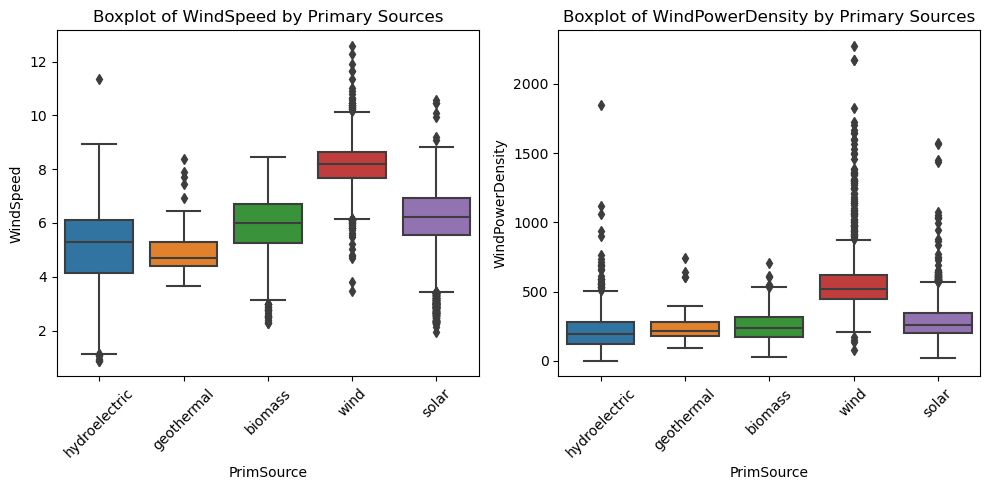

In [13]:
cols = ["WindSpeed", "WindPowerDensity"]

# Set number of rows and columns in subplot
sub_rows = 1
sub_cols = 2

# Set up grid of subplots
plt.subplots(sub_rows, sub_cols, figsize=(sub_cols*5, sub_rows*5))

# Initialize counter
subplot_ctr = 1

# Loop through column names in list
for col in cols:
    
    # Plot subplot in next location in grid
    plt.subplot(sub_rows, sub_cols, subplot_ctr)

    sns.boxplot(x="PrimSource", y=col, data=df)
    plt.title(f"Boxplot of {col} by Primary Sources")
    plt.xticks(rotation=45)
    
    # Add 1 to counter
    subplot_ctr += 1

# This ensures the subplots do not overlap
plt.tight_layout()
plt.show()

We can see that the mean or median of Wind Speed and Wind Power Density are different across the primary energy source classes. It would be appropriate to fill the null values using the median of Wind Speed and Wind Power Density by its primary source class. We are using the median because there are significant number of outliers.

### Fill the NaN in each factor column based on the Primary Source median column

In [14]:
for col in cols:
    numNa = df[col].isna().sum()

    if numNa > 0:
        print(f"Filling NaN for {col}")
        # view the distribution of primary source types for column is NaN
        print(df[df[col].isna()]["PrimSource"].value_counts())

        # Group the dataframe by PrimSource and calculate the median column for each group
        median_by_PrimSource = df.groupby('PrimSource')[col].median()

        # Fill NaN values in the column based on the PrimSource median Column
        df[col] = df.apply(lambda row: median_by_PrimSource[row['PrimSource']] if pd.isna(row[col]) else row[col], axis=1)

        # sanity check
        print(f"Sanity check. NaN for {col}: {df[col].isna().sum()}")

Filling NaN for WindSpeed
solar            12
hydroelectric    10
wind              2
biomass           2
Name: PrimSource, dtype: int64
Sanity check. NaN for WindSpeed: 0
Filling NaN for WindPowerDensity
solar            12
hydroelectric    10
wind              2
biomass           2
Name: PrimSource, dtype: int64
Sanity check. NaN for WindPowerDensity: 0


Now the data is cleaned, we can move on to more thorough EDA.

---

## EDA <a id="eda"></a>

In [17]:
# Get the columns of the geospatial data
df.columns[-7:]

Index(['WindSpeed', 'WindPowerDensity', 'SolarRadiation', 'AirTemperature',
       'CloudCoverIndex', 'Elevation', 'Slope'],
      dtype='object')

In [18]:
for factor in df.columns[-7:]:
    # Get count of the Renewable Power Plants by state
    tmp = df.groupby('State').agg(
        median=pd.NamedAgg(column=factor, aggfunc="median")
    )

    # Get Crosswalk From Generic Website
    cw_location = 'http://app02.clerk.org/menu/ccis/Help/CCIS%20Codes/'
    cw_filename = 'state_codes.html'
    states = pd.read_html(cw_location + cw_filename)[0]

    # Create New Variable With State Abbreviations
    state_code_map = dict(zip(states['Description'], 
                            states['Code']))
    tmp['StateCode'] = tmp.index.map(state_code_map)

    # Map the number of Renewable Power Plants
    fig = px.choropleth(
        locations=tmp['StateCode'],
        locationmode='USA-states',
        color=tmp['median'],
        scope='usa',
        title=f'Total Median of {factor} for Renewable Power Plants Per State'
    )
    fig.show()

### Save the cleaned dataframe to csv for other notebooks.

In [15]:
# Write the DataFrame to CSV file
df.to_csv("./data/capstone_data_cleaned.csv", index=False)

## Next Steps:

Data Preparation, EDA, and Initial Models